In [1]:
import pencil as pc
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel
import modes

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True

In [3]:
sim = pc.get_sim(quiet=True)
ts = pc.read.ts()
xyaver = pc.read.aver(plane_list=['xy'])

Read 3025 lines.


In [4]:
yaver = pc.read.aver(plane_list='y')

In [5]:
class EigenFunction(modes.Modes):
    """
    for plotting k-omega diagram and a few related analysis.
    """
    def __init__(self, t1, t2, sim, ts, xyaver, yaver, dyn=False):
        # super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=False)
        self.dyn = dyn
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=self.dyn)

        # self.a = super().gamma
        self.t1 = t1
        self.t2 = t2
        self.z_ref = np.argmin(np.abs(self.z-0))
        z_ref = np.argmin(np.abs(self.z-0))
        print(self.z_ref)

        self.indx_t1 = np.argmin(np.abs(self.yaver.t - self.t1))  #to avoid the transient effects below t=170
        self.indx_t2 = np.argmin(np.abs(self.yaver.t - self.t2))

        # self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,:]
        self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()
        pi = np.pi
        # self.xx = np.linspace(0,2*pi,100)
        self.kf = self.get_kf()
        
        self.P_om = np.exp(self.log_P)

        # def Power_filtered(self, power:np.ndarray, sigma):
        #     # P_filt = gaussian_filter(power[:self.upto_indx],sigma)
        #     P_filt = gaussian_filter(power[np.argmin(np.abs(self.om_til-0)):],sigma)
        #     return P_filt
        
    def f_freq(self, k_tilx, qq=False):
        # freq = round(self.fmodes(k_tilx),3)
        freq = self.fmodes(k_tilx, qq)
        return freq
    
    def p_freq(self, k_tilx, num):
        if isinstance(num, int):
            freq = self.pmodes(k_tilx,num)
        if isinstance(num, list):
            freq=[]
            for i in range(len(num)):
                freq.append(self.pmodes(k_tilx,i))
        return freq
    
    def mode_fit_extend(self, func, x, para, cont=True):
        if cont:
            y = func(x, *para)
        else:
            y = func(x, *para)-x*para[4]-para[3]
        return y



    def plot(self, z_ref, quad=False, detailed=False, **kwargs):
        """
        for plotting k-omega diagram in full or first quadrant.
        set quad=True to plot only in first quadrant.
        set detailed=True to plot theoretical curves on top of your k-omega diagram.
        you can also pass a specific keyword 'vmin' for now, which will let you fix
        the lowest value of logP, you want in your k-omega diagram.
        """

        if quad==False:
            kk = self.k_til
            oomm = self.om_til
            logP = self.log_P[:,:,z_ref]
        else:
            kk = self.k_til[np.argmin(np.abs(self.k_til-0)):]
            oomm = self.om_til[np.argmin(np.abs(self.om_til-0)):]
            logP = self.log_P[np.argmin(np.abs(self.om_til-0)):,np.argmin(np.abs(self.k_til-0)):,z_ref]

        if 'vmin' in kwargs.keys():
            if kwargs['vmin']=='min':
                vmin = np.min(logP)
            else:
                try:
                    vmin = float(kwargs['vmin'])
                except ValueError:
                    vmin = np.min(logP)
        else:
            vmin = -4
        print(vmin)
        if vmin<np.min(logP):
            print('provided vmin:', vmin, 'is less than minimum value of logP:', np.round(np.min(logP),2))
        # vmin = np.min(logP)
        vmax = np.max(logP)
        levels = np.linspace(vmin//1, vmax, 1000)
        
        #! creating meshgrid
        # [X, Y] = np.meshgrid(self.k_til, self.om_til)
        [X, Y] = np.meshgrid(kk, oomm)

        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(1,1,1)
        # img = ax.contourf(np.fft.fftshift(X), np.fft.fftshift(Y), np.fft.fftshift(self.log_P), levels=levels, cmap='afmhot_r', vmin=vmin, vmax=vmax, extend='min')
        img = ax.contourf(X, Y, logP, levels=levels, cmap='afmhot_r', vmin=vmin, vmax=vmax, extend='min')
        # img = ax.contourf(self.log_P, levels=levels, cmap='afmhot_r', vmin=vmin, vmax=vmax, extend='min')

        if detailed:
            if vmin<np.min(logP)+5:
                c = 'w'
            else:
                c = 'k'

            #! fmodes
            plt.plot(kk[np.argmin(np.abs(kk-0)):], 
                     np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)), ls='-.', c=c)
            plt.plot(kk[np.argmin(np.abs(kk-0)):], 
                     np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)*(1-self.q)/(1+self.q)), ls=(0, (3, 1, 1, 1, 1, 1)), c=c)
            
            if quad==False:
                xx = [-1,-1,1]
                yy = [1,-1,-1]
                for i in range(len(xx)):
                    plt.plot(xx[i]*kk[np.argmin(np.abs(kk-0)):], 
                        yy[i]*np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)), ls='-.', c=c)
                    plt.plot(xx[i]*kk[np.argmin(np.abs(kk-0)):], 
                        yy[i]*np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)*(1-self.q)/(1+self.q)), ls=(0, (3, 1, 1, 1, 1, 1)), c=c)
                
                #! pmodes
                for i in range(0, 16):
                    plt.plot(kk, self.pmodes(kk, i), c=c, ls=':')
                    plt.plot(kk, -self.pmodes(kk, i), c=c, ls=':')
                
                #! bounding lines
                plt.plot(kk, self.cs_d*kk/(self.omega0*self.L0), ls='solid', c=c, alpha=0.6)
                plt.plot(kk, self.cs_u*kk/(self.omega0*self.L0), ls='dashed', c=c, alpha=0.6)
                plt.plot(kk, -self.cs_d*kk/(self.omega0*self.L0), ls='solid', c=c, alpha=0.6)
                plt.plot(kk, -self.cs_u*kk/(self.omega0*self.L0), ls='dashed', c=c, alpha=0.6)
            else:
                #! pmodes
                for i in range(0, 16):
                    plt.plot(kk, self.pmodes(kk, i), c=c, ls=':')
                
                #! bounding lines
                plt.plot(kk, self.cs_d*kk/(self.omega0*self.L0), ls='solid', c=c, alpha=0.6)
                plt.plot(kk, self.cs_u*kk/(self.omega0*self.L0), ls='dashed', c=c, alpha=0.6)

        xlim = 10
        ylim = 10
        # plt.xlim(-self.kf,self.kf)
        if quad==False:
            plt.xlim(-xlim,xlim)
            # plt.ylim(-np.pi,np.pi)
            plt.ylim(-ylim,ylim)
        else:
            plt.xlim(0,xlim)
            plt.ylim(0,ylim)

        cbar = fig.colorbar(img, cax=None, ax=ax)#, label=r'$logP$')
        if vmin<np.min(logP)+5:
            ticks = np.arange(vmin//1+1, vmax, 2)
        else:
            ticks = np.arange(vmin//1+1, vmax)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(r'$lnP$', fontsize=14, labelpad=20)
        plt.xlabel(r"$\tilde{k}_x$")
        plt.ylabel(r"$\tilde{\omega}$")
        plt.tight_layout()
        plt.savefig(f'plots/k_om_{self.z_ref}.png')
        # plt.show()
    pass

In [6]:
planes = EigenFunction(150, 670, sim, ts, xyaver, yaver, dyn=False)

229


/scratch/cmondal/pc_data/dynamo_modes/test_dir/modes/with_2layer_cooling/magnetic/2layer_mod5a/modes.py:169: RuntimeWarning:

divide by zero encountered in log



In [7]:
# planes.plot(160, quad=True)
# plt.axhline(y=1.2)
# plt.axhline(y=2.2)

In [8]:
nz = 256
diff_z = 1
if diff_z==1:
    indx_planes = np.arange(0,nz,1)
else:
    indx_planes = np.append(np.arange(0,nz,1), nz)



z = np.zeros([len(indx_planes)])
P_dim = planes.P_om[:,:,0].shape
P_om_z = np.zeros([P_dim[0], P_dim[1], len(indx_planes)])
for i,value in enumerate(indx_planes):
    # print(i)
    P_om_z[:,:,i] = planes.P_om[:,:,value]
    z[i] = planes.grid.z[value]
P_dim, P_om_z.shape

((7403, 1024), (7403, 1024, 256))

In [9]:
indx_planes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
# z

In [11]:
np.save('pdata/P_om_z', P_om_z)

In [12]:
P = np.load('pdata/P_om_z.npy')

In [13]:
P.shape

(7403, 1024, 256)

In [14]:
k_indx = np.argmin(np.abs(planes.k_til-2))
planes.k_til[k_indx]

2.0

In [15]:
# P_filt.shape

In [16]:
label_kin = []
P_filt = np.empty(np.shape(P[:,0,:]))
# P_sat_filt = np.empty(np.shape(P_sat))
for i, indx in enumerate(P_filt[0,:]):
    P_filt[:,i] = convolve(P[:,k_indx,i], Box1DKernel(7))

In [17]:
len(P_filt[0,:])

256

In [18]:
# for i, indx in enumerate(P_filt[0,:]):
#     print(i, indx)

In [19]:
P_filt200 =convolve(P[:,k_indx,200], Box1DKernel(5))

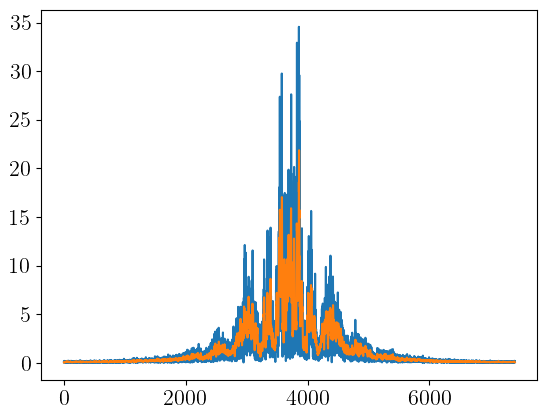

In [20]:
plt.plot(P[:,k_indx,200])
plt.plot(P_filt[:,200])

In [21]:
P_filt.shape

(7403, 256)

In [22]:
# filt = True
# if filt == True:
#     Power = P_filt
# else:
#     Power = P

In [23]:
list(P.shape)
dlim = 1.0
ulim = 1.9
f_mode_om_z = planes.om_til[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim))]

filt = True
filt = False
if filt == True:
    Power = P_filt
    f_mode_P_z = Power[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),:]
else:
    Power = P
    f_mode_P_z = Power[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,:]
# f_mode_P_z = P[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,:]
f_mode_P_z.shape

(53, 256)

In [24]:
f_om =planes.f_freq(planes.k_til[k_indx], qq=True)

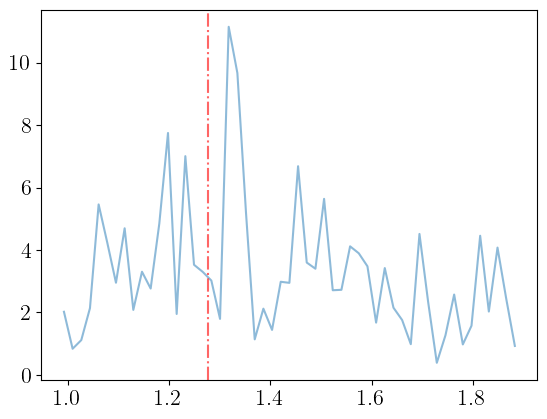

In [25]:
plt.plot(f_mode_om_z, f_mode_P_z[:,165], alpha=0.5)
# plt.plot(P_filt[:,165])
plt.axvline(x=f_om, ls='-.', c='r', alpha=0.6)

In [26]:
# f_mode = 

In [27]:
def lorentzian(x, a, b, c, d, e):
    y = a/((x-b)**2+np.exp(c))+d+e*x
    return y

def st_line(x, a, b):
    return a*x+b

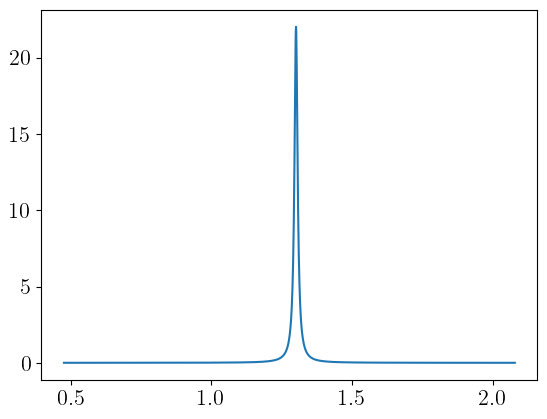

In [92]:
plt.plot(xf[100], lorentzian(xf[100], 0.001, 1.3, -10, 0, 0))

In [29]:
list(P.shape)

[7403, 1024, 256]

In [126]:
hm = P[0,0,:].shape[-1]
para_f = np.zeros((hm,5))
xf = np.zeros((hm,2000))
yf = np.zeros((hm,2000))
for i in range(hm):
    try:
        # para_f[i,:], _ = curve_fit(lorentzian, f_mode_om_z, f_mode_P_z[:,i], p0 = np.array([2,f_om,-2,1,1]), bounds=((0,1.2,-5,-5,-4),(20,1.5,5,5,4)))
        # para_f[i,:], _ = curve_fit(lorentzian, f_mode_om_z, f_mode_P_z[:,i], p0 = np.array([2,f_om,-2,1,1]), bounds=((0,1.2,-5,-np.inf,-4),(20,1.5,5,np.inf,4)))
        # para_f[i,:], _ = curve_fit(lorentzian, f_mode_om_z, f_mode_P_z[:,i], p0 = np.array([0.001,f_om,-6,1,1]), bounds=((0,1.2,-10,-np.inf,-6),(0.1,1.5,-5,np.inf,4)))
        para_f[i,:], _ = curve_fit(lorentzian, f_mode_om_z, f_mode_P_z[:,i], p0 = np.array([0.001,f_om,-2,1,1]), bounds=((0,1.2,-5,-np.inf,-6),(0.1,1.5,0,np.inf,4)))
    except RuntimeError:
        para_f[i,:] = [0,f_om,0,0,0]
    xf[i] = np.linspace(f_om-0.8, f_om+0.8, 2000)
    yf[i] = planes.mode_fit_extend(lorentzian, xf[i], para_f[i,:], cont=False)


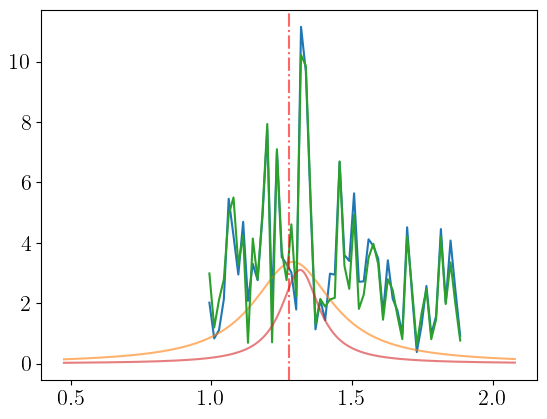

In [133]:
z_indx = 165
plt.plot(f_mode_om_z, f_mode_P_z[:,z_indx])
plt.plot(xf[z_indx], yf[z_indx,:], alpha=0.6)

plt.plot(f_mode_om_z, f_mode_P_z[:,162])
plt.plot(xf[162], yf[162,:], alpha=0.6)
plt.axvline(x=f_om, ls='-.', c='r', alpha=0.6)

In [128]:
from scipy.integrate import trapezoid

In [129]:
mode_mass_f = np.zeros([len(z)])
for i in range(len(z)):
    mode_mass_f[i] = trapezoid(yf[i], xf[i])

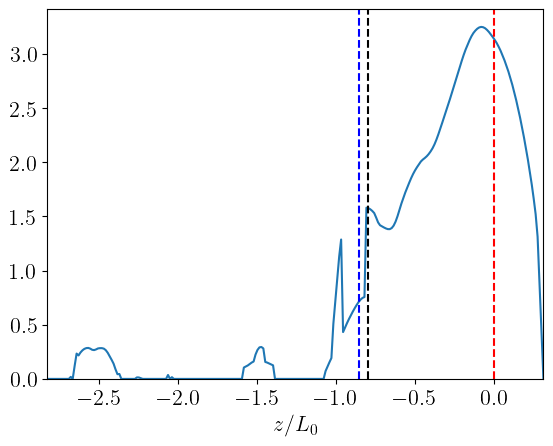

In [132]:
plt.plot(z, mode_mass_f)
plt.axvline(x=0, ls='--', c='r')
plt.axvline(x=z[165], ls='--', c='k')
plt.axvline(x=z[160], ls='--', c='b')
plt.xlim(planes.grid.z[0], planes.grid.z[-1])
plt.ylim(0,)
plt.xlabel(r'$z/L_0$')
# plt.savefig('f_eigenfunction_filt.png')
plt.savefig('f_eigenfunction.png')
plt.show()

### for lower regions

In [35]:
l_indx = 196
hm = P[0,0,:l_indx].shape[-1]
hm

196

In [36]:
list(P.shape)
dlim = 1.0
ulim = 1.9
f_mode_om_z_low = planes.om_til[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim))]
f_mode_P_z_low = P[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,:l_indx]
f_mode_P_z_low.shape

(53, 196)

In [37]:
hm = P[0,0,:l_indx].shape[-1]
para_f_low = np.zeros((hm,5))
xf_low = np.zeros((hm,2000))
yf_low = np.zeros((hm,2000))
for i in range(hm):
    try:
        # para_f[i,:], _ = curve_fit(lorentzian, f_mode_om_z, f_mode_P_z[:,i], p0 = np.array([2,f_om,-2,1,1]), bounds=((0,1.2,-5,-5,-4),(20,1.5,5,5,4)))
        # para_f[i,:], _ = curve_fit(lorentzian, f_mode_om_z, f_mode_P_z[:,i], p0 = np.array([2,f_om,-2,1,1]), bounds=((0,1.2,-5,-np.inf,-4),(20,1.5,5,np.inf,4)))
        para_f_low[i,:], _ = curve_fit(lorentzian, f_mode_om_z_low, f_mode_P_z_low[:,i], p0 = np.array([0.001,f_om,-2,1,1]), bounds=((0,1.2,-5,-np.inf,-6),(0.1,1.5,0,np.inf,4)))
    except RuntimeError:
        para_f_low[i,:] = [0,f_om,0,0,0]
    xf_low[i] = np.linspace(f_om-0.8, f_om+0.8, 2000)
    yf_low[i] = planes.mode_fit_extend(lorentzian, xf_low[i], para_f_low[i,:], cont=False)


In [38]:
xf_low[z_indx]

array([0.47650427, 0.47730467, 0.47810507, ..., 2.07490347, 2.07570387,
       2.07650427])

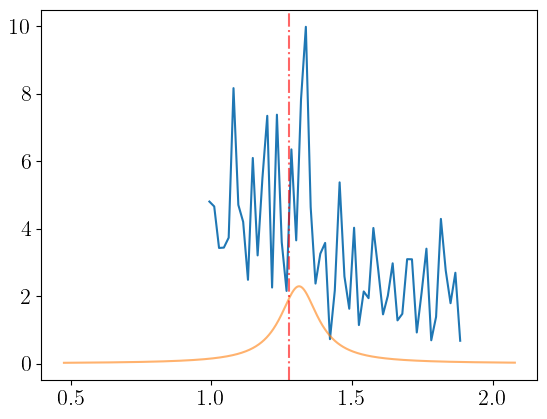

In [39]:
z_indx = 155
plt.plot(f_mode_om_z_low, f_mode_P_z_low[:,z_indx])
plt.plot(xf_low[z_indx], yf_low[z_indx,:], alpha=0.6)
plt.axvline(x=f_om, ls='-.', c='r', alpha=0.6)

In [40]:
mode_mass_f_low = np.zeros([hm])
for i in range(hm):
    mode_mass_f_low[i] = trapezoid(yf_low[i], xf_low[i])

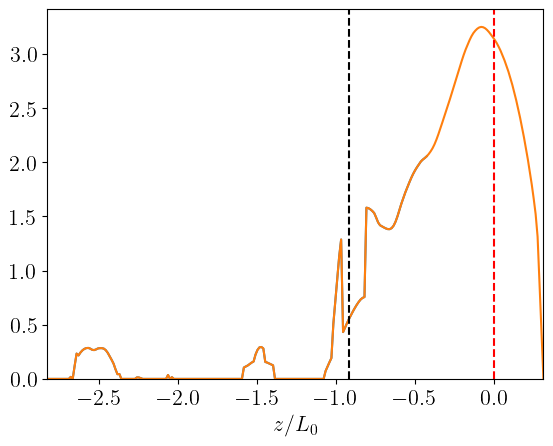

In [41]:
plt.plot(z[:l_indx], mode_mass_f_low)
plt.plot(z, mode_mass_f)
plt.axvline(x=0, ls='--', c='r')
plt.axvline(x=z[155], ls='--', c='k')
plt.xlim(planes.grid.z[0], planes.grid.z[-1])
plt.ylim(0,)
plt.xlabel(r'$z/L_0$')
plt.show()

## $p$-modes

In [42]:
list(P.shape)
dlim = 1.6
ulim = 2.55
p1_mode_om_z = planes.om_til[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim))]
filt = False
if filt == True:
    Power = P_filt
    p1_mode_P_z = Power[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),:]
else:
    Power = P
    p1_mode_P_z = Power[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,:]
# p1_mode_P_z = P[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,:]
p1_mode_P_z.shape

(56, 256)

In [43]:
p1_om =planes.p_freq(planes.k_til[k_indx],0)
p1_om

2.1376918717846234

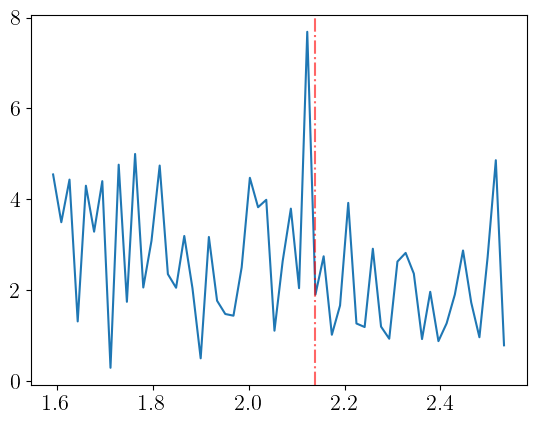

In [44]:
plt.plot(p1_mode_om_z, p1_mode_P_z[:,82])
plt.axvline(x=p1_om, ls='-.', c='r', alpha=0.6)

In [67]:
hm = P[0,0,:].shape[-1]
para_p1 = np.zeros((hm,5))
xp1 = np.zeros((hm,2000))
yp1 = np.zeros((hm,2000))

for i in range(hm):
    xp1[i] = np.linspace(p1_om-0.8, p1_om+0.8, 2000)

    try:
        # para_p1[i,:], _ = curve_fit(lorentzian, p1_mode_om_z, p1_mode_P_z[:,i], p0 = np.array([2,p1_om,-2,1,1]), bounds=((0,2.0,-5,-5,-2),(20,2.5,5,5,2)))
        para_p1[i,:], _ = curve_fit(lorentzian, p1_mode_om_z, p1_mode_P_z[:,i], p0 = np.array([2,p1_om,-2,1,1]), bounds=((0,2.0,-5,-5,-2),(20,2.5,5,5,2)))
        yp1[i] = planes.mode_fit_extend(lorentzian, xp1[i], para_p1[i,:], cont=False)
    except RuntimeError:
        print(i)
        # para_p1[i,:] = [0,p1_om,0,0,0]
        para_p1[i,:], _ = curve_fit(st_line, p1_mode_om_z, p1_mode_P_z[:,i], p0 = np.array([1,1]), bounds=((-5,-2),(5,2)))
        yp1[i] = planes.mode_fit_extend(st_line, xp1[i], para_p1[i,:], cont=False)


In [68]:
para_p1.shape, yp1.shape

((256, 5), (256, 2000))

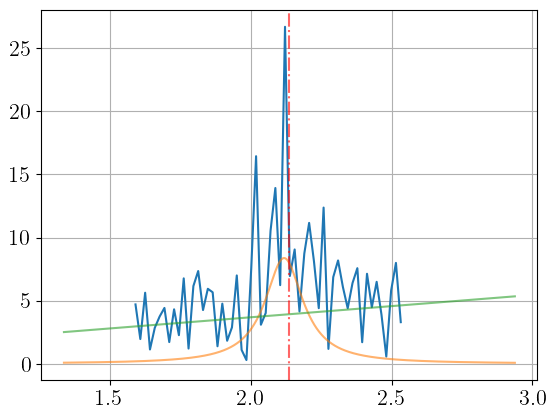

In [69]:
z_indx = 182
plt.plot(p1_mode_om_z, p1_mode_P_z[:,z_indx])
plt.plot(xp1[z_indx], yp1[z_indx,:], alpha=0.6)
plt.plot(xp1[z_indx], xp1[z_indx]*para_p1[z_indx,4]+para_p1[z_indx,3], alpha=0.6)
plt.axvline(x=p1_om, ls='-.', c='r', alpha=0.6)
plt.grid()

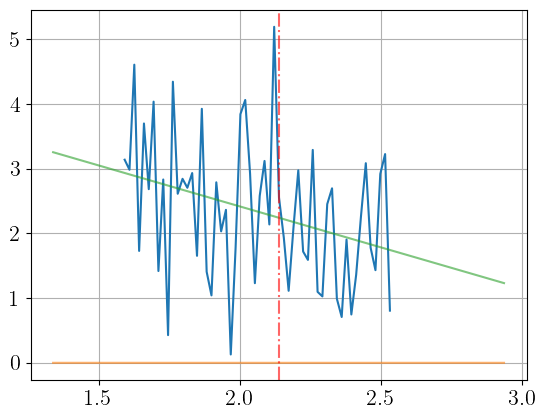

In [70]:
z_indx = 72
plt.plot(p1_mode_om_z, p1_mode_P_z[:,z_indx])
plt.plot(xp1[z_indx], yp1[z_indx,:], alpha=0.6)
plt.plot(xp1[z_indx], xp1[z_indx]*para_p1[z_indx,4]+para_p1[z_indx,3], alpha=0.6)
plt.axvline(x=p1_om, ls='-.', c='r', alpha=0.6)
plt.grid()

In [71]:
mode_mass_p1 = np.zeros([len(z)])
for i in range(len(z)):
    mode_mass_p1[i] = trapezoid(yp1[i], xp1[i])

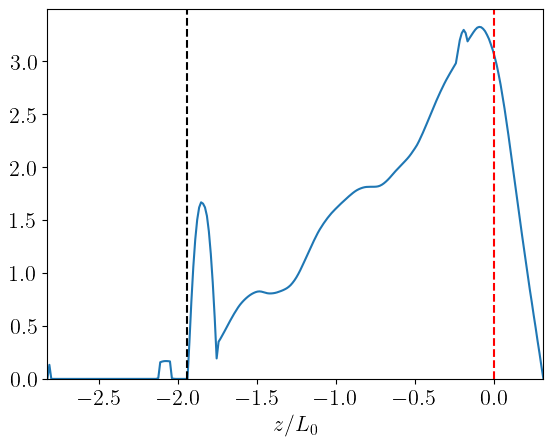

In [72]:
plt.plot(z, mode_mass_p1)
plt.axvline(x=0, ls='--', c='r')
plt.axvline(x=z[72], ls='--', c='k')
plt.xlim(planes.grid.z[0], planes.grid.z[-1])
plt.ylim(0,)
plt.xlabel(r'$z/L_0$')
plt.show()

In [51]:
list(P.shape)
dlim = 2.3
ulim = 3.1
p2_mode_om_z = planes.om_til[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim))]
p2_mode_P_z = P[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,:]
p2_mode_P_z.shape

(47, 256)

In [52]:
p2_om =planes.p_freq(planes.k_til[k_indx],1)
p2_om

2.668174336748295

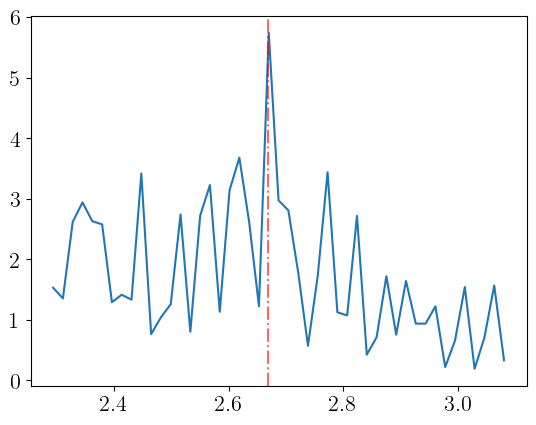

In [53]:
plt.plot(p2_mode_om_z, p2_mode_P_z[:,25])
plt.axvline(x=p2_om, ls='-.', c='r', alpha=0.6)

In [155]:
hm = P[0,0,:].shape[-1]
para_p2 = np.zeros((hm,5))
xp2 = np.zeros((hm,2000))
yp2 = np.zeros((hm,2000))
for i in range(hm):
    try:
        # para_p2[i,:], _ = curve_fit(lorentzian, p2_mode_om_z, p2_mode_P_z[:,i], p0 = np.array([2,p2_om,-2,1,1]), bounds=((0,2.55,-5,-5,-2),(20,3.0,5,5,2)))
        # para_p2[i,:], _ = curve_fit(lorentzian, p2_mode_om_z, p2_mode_P_z[:,i], p0 = np.array([2,p2_om,-2,1,1]), bounds=((0,2.55,-5,-5,-2),(20,3.0,5,5,2)))
        para_p2[i,:], _ = curve_fit(lorentzian, p2_mode_om_z, p2_mode_P_z[:,i], p0 = np.array([2,p2_om,-4,1,1]), bounds=((0,2.55,-9,-5,-2),(20,3.0,-2,5,2)))
    except RuntimeError:
        para_p2[i,:] = [0,p2_om,0,0,0]
    xp2[i] = np.linspace(p2_om-0.8, p2_om+0.8, 2000)
    yp2[i] = planes.mode_fit_extend(lorentzian, xp2[i], para_p2[i,:], cont=False)


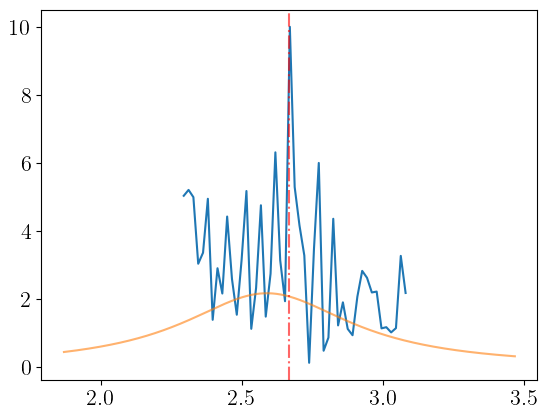

In [156]:
z_indx = 159
plt.plot(p2_mode_om_z, p2_mode_P_z[:,z_indx])
plt.plot(xp2[z_indx], yp2[z_indx,:], alpha=0.6)
plt.axvline(x=p2_om, ls='-.', c='r', alpha=0.6)

In [157]:
mode_mass_p2 = np.zeros([len(z)])
for i in range(len(z)):
    mode_mass_p2[i] = trapezoid(yp2[i], xp2[i])

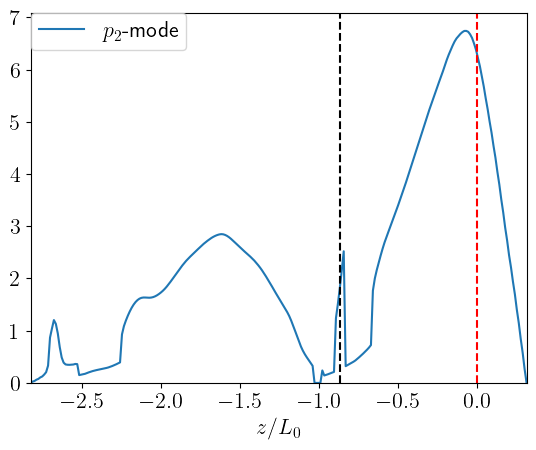

In [158]:
plt.plot(z, mode_mass_p2, label=r'$p_2$-mode')
plt.axvline(x=0, ls='--', c='r')
# plt.axvline(x=z[156], ls='--', c='k')
plt.axvline(x=z[159], ls='--', c='k')
plt.xlim(planes.grid.z[0], planes.grid.z[-1])
plt.ylim(0,)
plt.xlabel(r'$z/L_0$')
plt.legend(loc=(0,0.9))
plt.show()

In [58]:
list(P.shape)
dlim = 2.3
ulim = 3.2
p2_mode_om_z_n = planes.om_til[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim))]
p2_mode_P_z_n = P[np.argmin(np.abs(planes.om_til-dlim)):np.argmin(np.abs(planes.om_til-ulim)),k_indx,155:172]
p2_mode_P_z_n.shape

(53, 17)

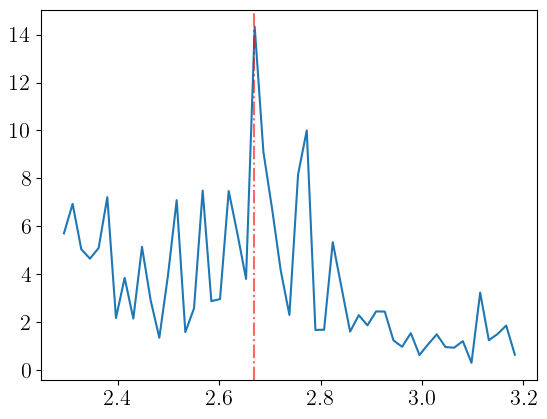

In [59]:
plt.plot(p2_mode_om_z_n, p2_mode_P_z_n[:,14])
plt.axvline(x=p2_om, ls='-.', c='r', alpha=0.6)

In [159]:
hm = P[0,0,155:172].shape[-1]
para_p2_n = np.zeros((hm,5))
xp2_n = np.zeros((hm,2000))
yp2_n = np.zeros((hm,2000))
for i in range(hm):
    try:
        # para_p2_n[i,:], _ = curve_fit(lorentzian, p2_n_mode_om_z, p2_n_mode_P_z[:,i], p0 = np.array([2,p2_n_om,-2,1,1]), bounds=((0,2.55,-5,-5,-2),(20,3.0,5,5,2)))
        para_p2_n[i,:], _ = curve_fit(lorentzian, p2_mode_om_z, p2_mode_P_z[:,i], p0 = np.array([0.01,p2_om,-2,1,1]), bounds=((0,2.55,-np.inf,-5,-2),(0.1,3.0,0,5,2)))
    except RuntimeError:
        para_p2_n[i,:] = [0,p2_om,0,0,0]
    xp2_n[i] = np.linspace(p2_om-0.8, p2_om+0.8, 2000)
    yp2_n[i] = planes.mode_fit_extend(lorentzian, xp2_n[i], para_p2_n[i,:], cont=False)


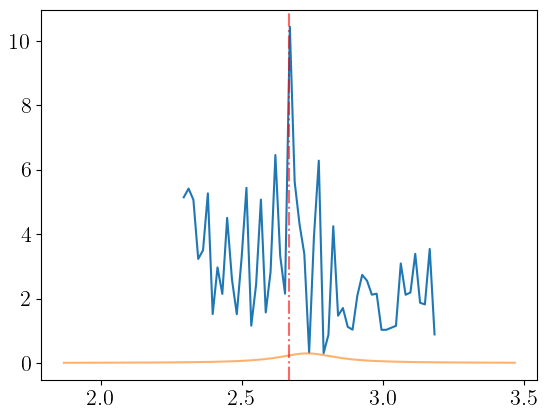

In [160]:
z_indx = 5
plt.plot(p2_mode_om_z_n, p2_mode_P_z_n[:,z_indx])
plt.plot(xp2_n[z_indx], yp2_n[z_indx,:], alpha=0.6)
plt.axvline(x=p2_om, ls='-.', c='r', alpha=0.6)

In [161]:
hm

17

In [162]:
mode_mass_p2_n = np.zeros([hm])
for i in range(hm):
    mode_mass_p2_n[i] = trapezoid(yp2_n[i], xp2_n[i])

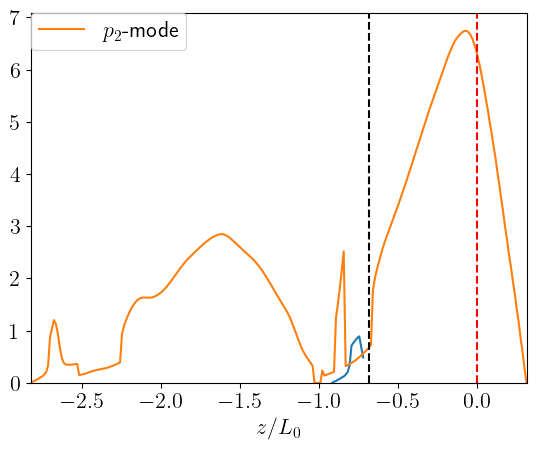

In [163]:
plt.plot(z[155:172], mode_mass_p2_n)
plt.plot(z, mode_mass_p2, label=r'$p_2$-mode')
plt.axvline(x=0, ls='--', c='r')
plt.axvline(x=z[174], ls='--', c='k')
plt.xlim(planes.grid.z[0], planes.grid.z[-1])
plt.ylim(0,)
plt.xlabel(r'$z/L_0$')
plt.legend(loc=(0,0.9))
plt.show()